In [1]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import AdultDataset
from aif360.datasets import StandardDataset
from aif360.sklearn.datasets import fetch_adult

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, auc, roc_curve

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.algorithms.postprocessing import EqOddsPostprocessing


np.random.seed(1)

pip install 'aif360[AdversarialDebiasing]'


In [2]:
X, y, sample_weight = fetch_adult()

In [3]:
df = X
df['y'] = y
df.head()

,,,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
,race,sex,,,,,,,,,,,,,,
0,Non-white,Male,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Non-white,Male,0.0,0.0,40.0,United-States,<=50K
1,White,Male,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,White,Male,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,Non-white,Male,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Non-white,Male,7688.0,0.0,40.0,United-States,>50K
5,White,Male,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K


In [4]:
df.columns = ['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race1', 'sex1', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'y']

df = df.reset_index()
df.drop(columns=['level_0', 'race', 'sex'], inplace = True)

df.columns = ['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'y']
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Non-white,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Non-white,Male,7688.0,0.0,40.0,United-States,>50K
4,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K


In [5]:
df.shape

(45222, 14)

In [6]:
df.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'y'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  float64 
 1   workclass       45222 non-null  category
 2   education       45222 non-null  category
 3   education-num   45222 non-null  float64 
 4   marital-status  45222 non-null  category
 5   occupation      45222 non-null  category
 6   relationship    45222 non-null  category
 7   race            45222 non-null  category
 8   sex             45222 non-null  category
 9   capital-gain    45222 non-null  float64 
 10  capital-loss    45222 non-null  float64 
 11  hours-per-week  45222 non-null  float64 
 12  native-country  45222 non-null  category
 13  y               45222 non-null  category
dtypes: category(9), float64(5)
memory usage: 2.1 MB


In [8]:
category = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'y']

In [9]:
for c in category:
    df[c] = df[c].astype('object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             45222 non-null  float64
 1   workclass       45222 non-null  object 
 2   education       45222 non-null  object 
 3   education-num   45222 non-null  float64
 4   marital-status  45222 non-null  object 
 5   occupation      45222 non-null  object 
 6   relationship    45222 non-null  object 
 7   race            45222 non-null  object 
 8   sex             45222 non-null  object 
 9   capital-gain    45222 non-null  float64
 10  capital-loss    45222 non-null  float64
 11  hours-per-week  45222 non-null  float64
 12  native-country  45222 non-null  object 
 13  y               45222 non-null  object 
dtypes: float64(5), object(9)
memory usage: 4.8+ MB


In [11]:
df.isna().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
y                 0
dtype: int64

## Eksploratorna analiza

In [12]:
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [13]:
df.describe(include= object)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,y
count,45222,45222,45222,45222,45222,45222,45222,45222,45222
unique,7,16,7,14,6,2,2,41,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,33307,14783,21055,6020,18666,38903,30527,41292,34014


In [14]:
df.groupby(['y'])[['age', 'capital-gain', 'capital-loss', 'hours-per-week']].agg([np.mean, np.std])

age            capital-gain               capital-loss  \
            mean        std         mean           std         mean   
y                                                                     
<=50K  36.749427  13.564683   149.023402    927.447387    54.032428   
>50K   44.006067  10.340502  3991.791667  14616.543746   193.487063   

                  hours-per-week             
              std           mean        std  
y                                            
<=50K  312.220461      39.372023  11.974127  
>50K   592.642319      45.690489  10.797764

In [15]:
df.groupby(['y','race', 'sex'])['age', 'capital-gain', 'capital-loss', 'hours-per-week'].agg(['count', np.mean, np.std])

C:\Users\milica.perisic\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


age                       capital-gain               \
                        count       mean        std        count         mean   
y     race      sex                                                             
<=50K Non-white Female   2598  37.094303  12.670826         2598   103.373364   
                Male     2720  36.237132  12.639542         2720   152.897426   
      White     Female  10428  36.148926  14.244558        10428   129.248849   
                Male    18268  37.119444  13.408292        18268   166.226735   
>50K  Non-white Female    214  41.004673   8.877623          214  5272.014019   
                Male      787  43.659466   9.903140          787  4054.251588   
      White     Female   1455  42.188316  10.436960         1455  4053.623368   
                Male     8752  44.412820  10.351968         8752  3944.592322   

                                     capital-loss                          \
                                 std        count        mean         std   
y     race      sex                                                         
<=50K Non-white Female    644.603671         2598   40.853734  264.803007   
                Male     1088.258214         2720   48.511397  298.606848   
      White     Female    871.394801        10428   47.322689  294.166453   
                Male      965.402987        18268   60.558846  329.813274   
>50K  Non-white Female  18109.506008          214  128.528037  493.482286   
                Male    14592.206806          787  186.313850  574.308341   
      White     Female  13902.560094         1455  189.914777  599.200798   
                Male    14640.288073         8752  196.314328  595.375269   

                       hours-per-week                        
                                count       mean        std  
y     race      sex                                          
<=50K Non-white Female           2598  37.024249   9.748028  
                Male             2720  39.743750  10.992030  
      White     Female          10428  36.234081  11.836753  
                Male            18268  41.441811  12.032972  
>50K  Non-white Female            214  42.514019  10.129087  
                Male              787  45.048285  10.191185  
      White     Female           1455  40.957388  11.640221  
                Male             8752  46.612774  10.493604

In [16]:
df.groupby(['y', 'sex'])['age', 'capital-gain', 'capital-loss', 'hours-per-week'].agg(['count', np.mean, np.std])

C:\Users\milica.perisic\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


age                       capital-gain               \
              count       mean        std        count         mean   
y     sex                                                             
<=50K Female  13026  36.337479  13.949518        13026   124.088055   
      Male    20988  37.005098  13.314176        20988   164.499285   
>50K  Female   1669  42.036549  10.255512         1669  4209.846016   
      Male     9539  44.350666  10.317257         9539  3953.639585   

                           capital-loss                          \
                       std        count        mean         std   
y     sex                                                         
<=50K Female    831.159241        13026   46.032474  288.550460   
      Male      982.174134        20988   58.997522  325.955961   
>50K  Female  14509.610287         1669  182.043739  586.938302   
      Male    14635.595204         9539  195.489255  593.642543   

             hours-per-week                        
                      count       mean        std  
y     sex                                          
<=50K Female          13026  36.391678  11.454624  
      Male            20988  41.221746  11.916611  
>50K  Female           1669  41.156980  11.466636  
      Male             9539  46.483699  10.477308

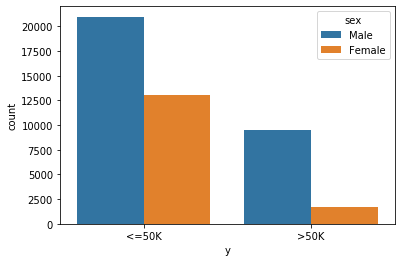

In [17]:
sns.countplot(x='y', hue='sex', data=df)

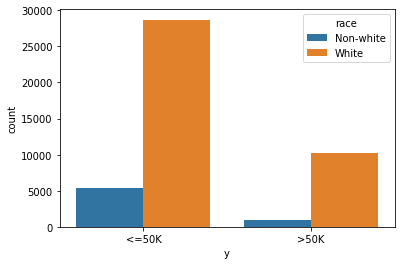

In [18]:
sns.countplot(x='y', hue='race', data=df)

In [19]:
numerical = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

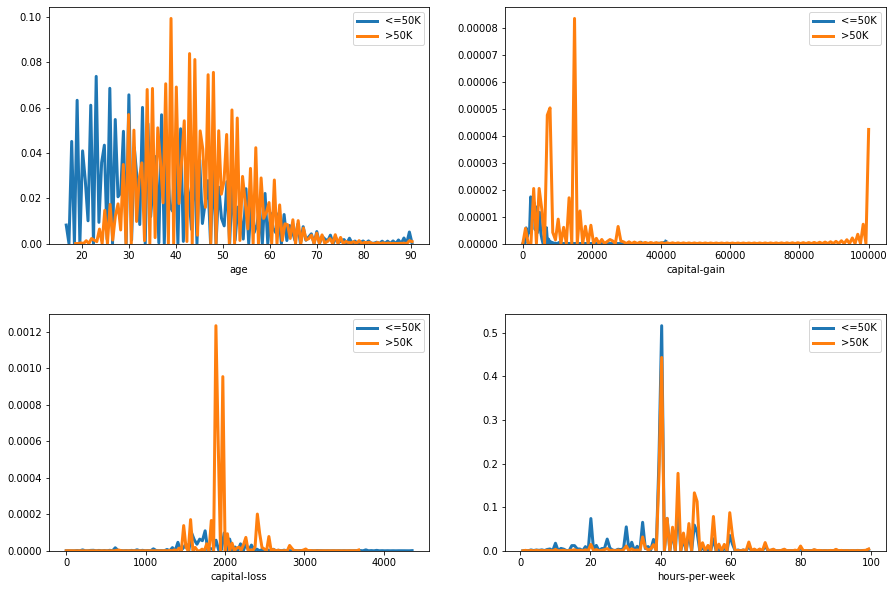

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
hue = ['<=50K', '>50K']
for ax, catplot in zip(axes.flatten(), df[numerical].columns):
    for h in hue:
        subset = df[df['y'] == h]
        sns.distplot(subset[catplot], ax = ax, hist = False, kde = True,
                 kde_kws = {'linewidth': 3, 'bw': 0.1},
                 label = h)

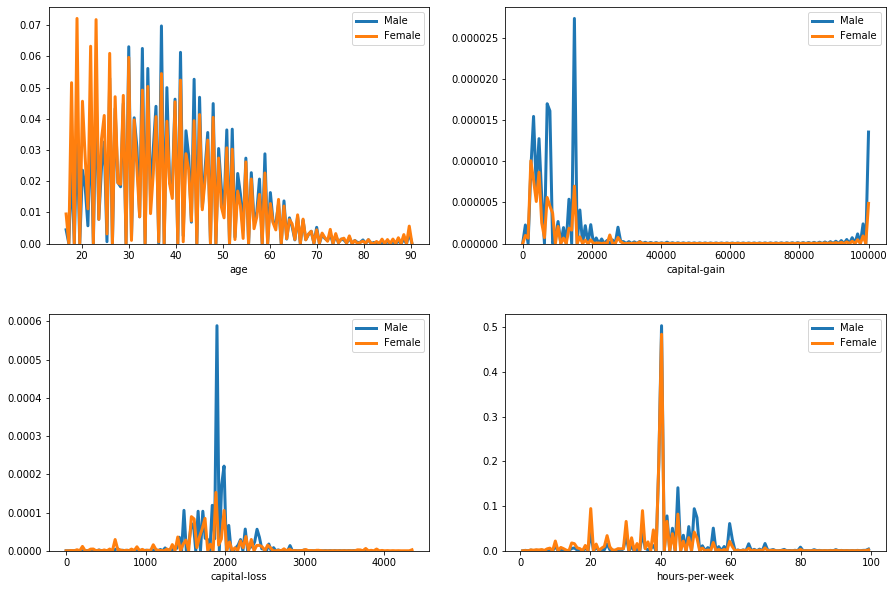

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
hue = ['Male', 'Female']
for ax, catplot in zip(axes.flatten(), df[numerical].columns):
    for h in hue:
        subset = df[df['sex'] == h]
        sns.distplot(subset[catplot], ax = ax, hist = False, kde = True,
                 kde_kws = {'linewidth': 3, 'bw': 0.1},
                 label = h)

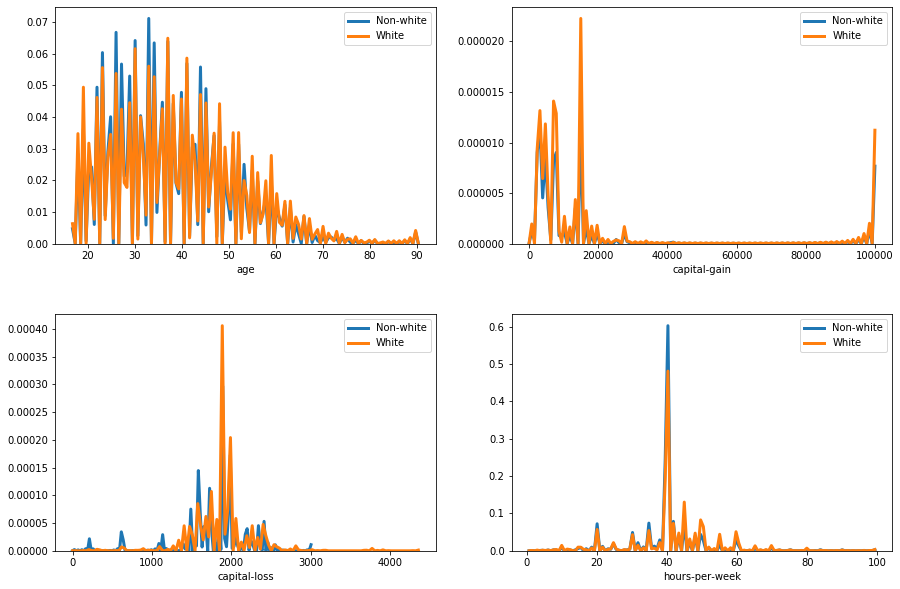

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)
hue = ['Non-white', 'White']
for ax, catplot in zip(axes.flatten(), df[numerical].columns):
    for h in hue:
        subset = df[df['race'] == h]
        sns.distplot(subset[catplot], ax = ax, hist = False, kde = True,
                 kde_kws = {'linewidth': 3, 'bw': 0.1},
                 label = h)

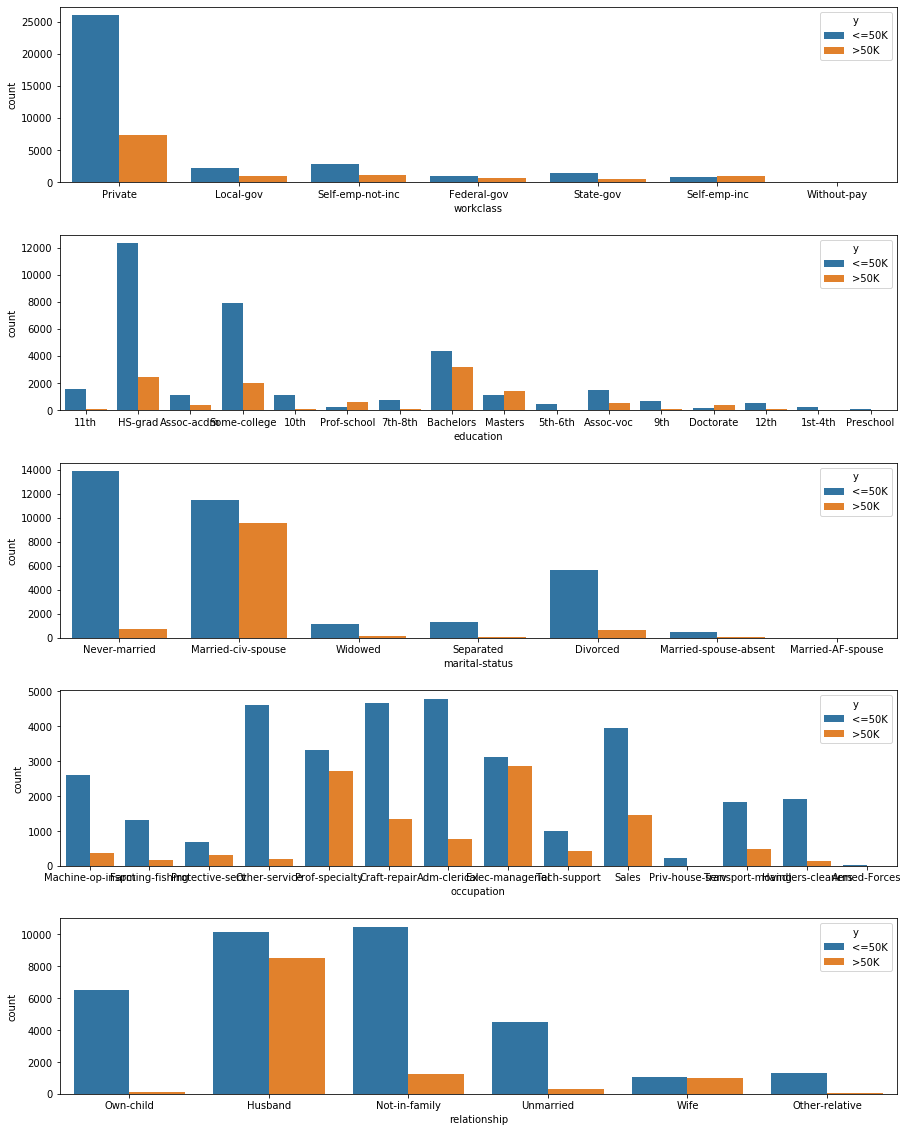

In [23]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship']
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,20))
fig.subplots_adjust(hspace=0.3)
for ax, catplot in zip(axes.flatten(), df[categorical].columns):
     sns.countplot(x=catplot, hue = 'y', data=df, ax=ax)

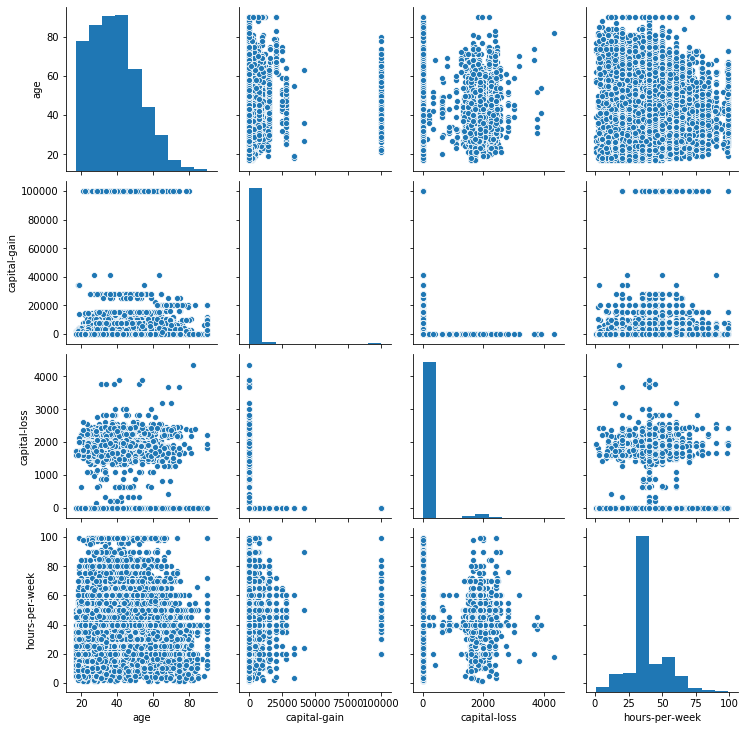

In [24]:
sns.pairplot(df[numerical])

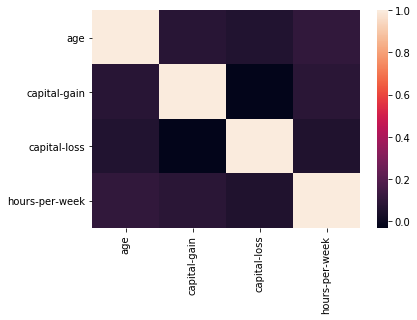

In [25]:
numerics = df[numerical]
corr_matrix = numerics.corr(method='pearson')

sns.heatmap(corr_matrix)

## Kategorički podaci

In [26]:
df[category].columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'y'],
      dtype='object')

In [27]:
df.drop(columns = ['education'], inplace = True)

In [28]:
df = pd.get_dummies(df, columns=['workclass', 'marital-status', 'occupation',
       'relationship','native-country',], prefix = ['workclass', 'marital', 'occupation',
       'relationship', 'country'])
df = df.drop(columns=['workclass_Without-pay', 'marital_Married-AF-spouse', 'occupation_Armed-Forces', 'relationship_Other-relative', 'country_Holand-Netherlands'])

In [29]:
df.shape

(45222, 78)

In [30]:
df.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,y,workclass_Federal-gov,workclass_Local-gov,...,country_Portugal,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Vietnam,country_Yugoslavia
0,25.0,7.0,Non-white,Male,0.0,0.0,40.0,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38.0,9.0,White,Male,0.0,0.0,50.0,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28.0,12.0,White,Male,0.0,0.0,40.0,>50K,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44.0,10.0,Non-white,Male,7688.0,0.0,40.0,>50K,0,0,...,0,0,0,0,0,0,0,1,0,0
4,34.0,6.0,White,Male,0.0,0.0,30.0,<=50K,0,0,...,0,0,0,0,0,0,0,1,0,0


In [31]:
df['y'] = df['y'].map({'<=50K':0, '>50K':1})

In [32]:
df['race'] = df['race'].map({'Non-white':0, 'White':1})

In [33]:
df['sex'] = df['sex'].map({'Female':0, 'Male':1})

In [34]:
df.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,y,workclass_Federal-gov,workclass_Local-gov,...,country_Portugal,country_Puerto-Rico,country_Scotland,country_South,country_Taiwan,country_Thailand,country_Trinadad&Tobago,country_United-States,country_Vietnam,country_Yugoslavia
0,25.0,7.0,0,1,0.0,0.0,40.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38.0,9.0,1,1,0.0,0.0,50.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28.0,12.0,1,1,0.0,0.0,40.0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,44.0,10.0,0,1,7688.0,0.0,40.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,34.0,6.0,1,1,0.0,0.0,30.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
df.columns

Index(['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'y', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov', 'marital_Divorced',
       'marital_Married-civ-spouse', 'marital_Married-spouse-absent',
       'marital_Never-married', 'marital_Separated', 'marital_Widowed',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'relationship_Husband',
       'relationship_Not-in-family', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife', 'coun

### Izuzeci

In [36]:
from scipy import stats

z = np.abs(stats.zscore(df[numerical]))
outliers = df[(z > 3).all(axis=1)]
outliers.shape

(0, 78)

## Fairness


In [37]:
### probala sam da koristim StandardDataset, pa da samo postojeci df prebacim u aif medjutim davalo mi je gresku da 
### ne prepoznaje tip podatka i nisam jos uspela da sredjen set prebacim tako, pa je zbog toga ova komanda ispod

In [38]:
df = AdultDataset()

In [39]:
sens_ind = 1
sens_attr = df.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       df.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     df.privileged_protected_attributes[sens_ind]]

In [40]:
unprivileged_groups

[{'sex': 0.0}]

In [41]:
privileged_groups

[{'sex': 1.0}]

In [42]:
def describe_dataset(train=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
  
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

In [43]:
(df_train, df_test) = df.split([0.8], shuffle=True)

In [44]:
describe_dataset(train=df_train, test=df_test)

#### Training Dataset shape

(36177, 98)


#### Test Dataset shape

(9045, 98)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['race', 'sex']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Married-civ-spouse', 'marital-status=Married-spouse-absent', 'marital-status=Never-married', 'marital-status=Separated', 'marital-status=Widowed', 'occupation=Adm-clerical', 'occupation=Armed-Forces', 'occupation=Craft-repair', 'occupation=Exec-managerial', 'occupation=Farming-fishing', 'occupation=Handlers-cleane

### Pomoćne funkcije

In [45]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        y_pred_proba = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        y_pred_proba = model.predict(dataset).scores

        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_pred = (y_pred_proba[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_pred
       
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
        
        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)   
        if 'PrejudiceRemover' in str(model):
            metric_arrs['roc_auc'].append(roc_auc_score(dataset.labels.ravel(), y_pred_proba.ravel()))
        else:
            metric_arrs['roc_auc'].append(roc_auc_score(dataset.labels.ravel(), y_pred_proba[:,1]))
        metric_arrs['precision'].append(metric.precision())
        metric_arrs['recall'].append(metric.recall())
        
        
        
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
    
    return metric_arrs

In [46]:
def get_metric(dataset, model, threshold):
    try:
        y_pred_proba = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        y_pred_proba = model.predict(dataset).scores
        pos_ind = 0
    
    y_pred = (y_pred_proba[:, pos_ind] > threshold).astype(np.float64)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
    return metric

In [47]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Classification metrics:")
    print("Roc auc score: {:6.4f}".format(metrics['roc_auc'][best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    print("Corresponding precision: {:6.4f}".format(metrics['precision'][best_ind]))
    print("Corresponding recall: {:6.4f}".format(metrics['recall'][best_ind]))
    
    print("Fairness metrics:")
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))

    

In [48]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.9)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.9)
    else:
        ax2.set_ylim(-0.25, 0.2)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

In [49]:
def get_predictions(dataset, model):
    try:
        y_pred_proba = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        y_pred_proba = model.predict(dataset).scores
        pos_ind = 0
    

    return y_pred_proba

In [50]:
def plot_roc_curve(fpr, tpr, roc_auc):
    fig, ax1 = plt.subplots(figsize=(10,7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [51]:
def get_best_metrics(metrics, best_ind):
    best_metrics = defaultdict(list)
    
    for metric in metrics:
        best_metrics[metric].append(metrics[metric][best_ind])
        
    return best_metrics

In [52]:
def get_metric_report(metric):
    metric_arrs = defaultdict(list)
    metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                 + metric.true_negative_rate()) / 2)   
#     if 'PrejudiceRemover' in str(model):
#         metric_arrs['roc_auc'].append(roc_auc_score(dataset.labels.ravel(), y_pred_proba.ravel()))
#     else:
#         metric_arrs['roc_auc'].append(roc_auc_score(dataset.labels.ravel(), y_pred_proba[:,1]))
    metric_arrs['precision'].append(metric.precision())
    metric_arrs['roc_auc'].append('none')
    metric_arrs['recall'].append(metric.recall())
    



    metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
    metric_arrs['disp_imp'].append(metric.disparate_impact())
    metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
    metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
    
    return metric_arrs

## Originalni set podataka

### Logistička regresija


In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
dataset = df_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

model_lr = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### Evaluacija 

In [55]:
thresh_arr = np.linspace(0.01, 0.7, 50)
test_metrics = test(dataset=df_test,
                   model=model_lr,
                   thresh_arr=thresh_arr)
lr_best_ind = np.argmax(test_metrics['bal_acc'])


In [56]:
lr_orig_metrics = get_best_metrics(test_metrics, lr_best_ind)

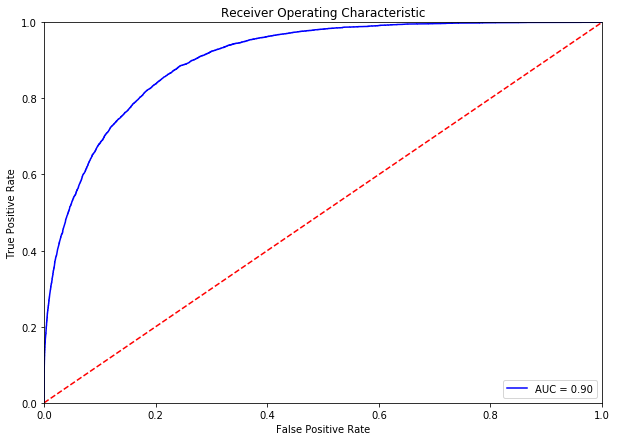

In [57]:
y_pred_proba = get_predictions(dataset, model_lr)

fpr, tpr, thresholds = roc_curve(dataset.labels.ravel(), y_pred_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

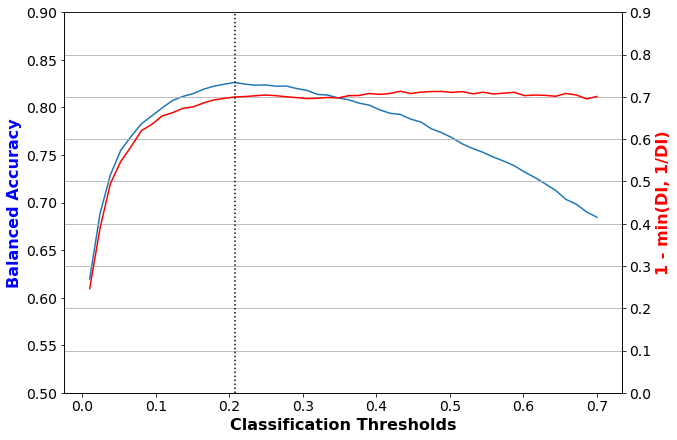

In [58]:
disp_imp = np.array(test_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

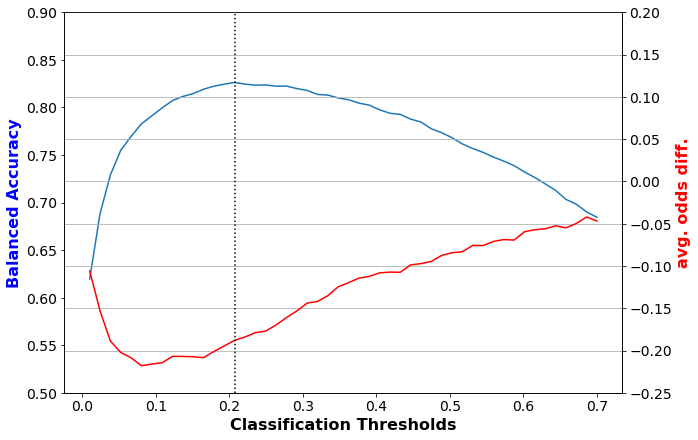

In [59]:
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     test_metrics['avg_odds_diff'], 'avg. odds diff.')

In [60]:
describe_metrics(test_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2071
Classification metrics:
Roc auc score: 0.9084
Best balanced accuracy: 0.8263
Corresponding precision: 0.5549
Corresponding recall: 0.8854
Fairness metrics:
Corresponding 1-min(DI, 1/DI) value: 0.6997
Corresponding average odds difference value: -0.1879
Corresponding statistical parity difference value: -0.3560
Corresponding equal opportunity difference value: -0.1208


## Random Forest

In [61]:
dataset = df_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
model_rf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### Evaluacija

In [62]:
thresh_arr = np.linspace(0.01, 0.7, 50)
test_metrics = test(dataset=df_test,
                   model=model_rf,
                   thresh_arr=thresh_arr)
rf_best_ind = np.argmax(test_metrics['bal_acc'])

In [63]:
rf_orig_metrics = get_best_metrics(test_metrics, rf_best_ind)

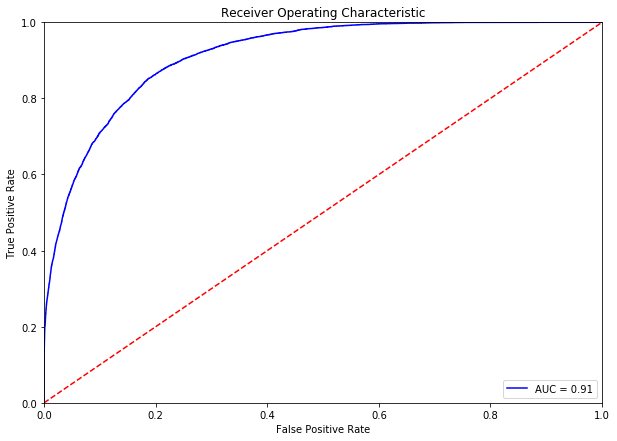

In [64]:
y_pred_proba = get_predictions(dataset, model_rf)

fpr, tpr, thresholds = roc_curve(dataset.labels.ravel(), y_pred_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

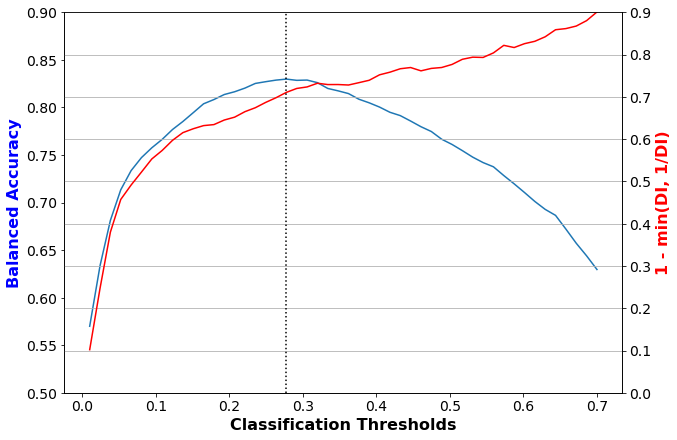

In [65]:
disp_imp = np.array(test_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

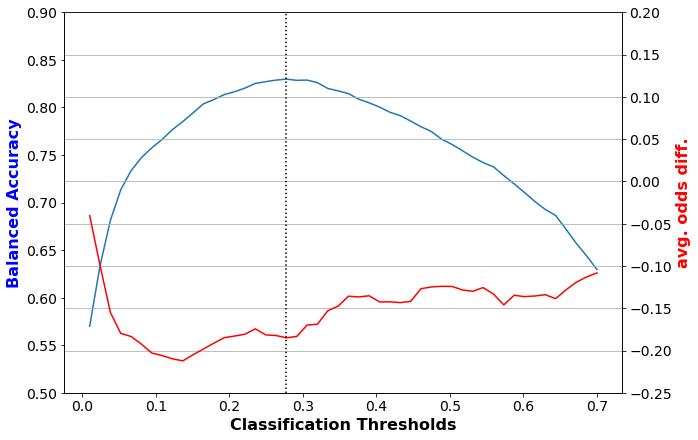

In [66]:
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     test_metrics['avg_odds_diff'], 'avg. odds diff.')

In [67]:
describe_metrics(test_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2776
Classification metrics:
Roc auc score: 0.9140
Best balanced accuracy: 0.8298
Corresponding precision: 0.5812
Corresponding recall: 0.8634
Fairness metrics:
Corresponding 1-min(DI, 1/DI) value: 0.7106
Corresponding average odds difference value: -0.1850
Corresponding statistical parity difference value: -0.3381
Corresponding equal opportunity difference value: -0.1425


## Tehnike pretprocesiranja 

### Reweightening

In [68]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
df_transf_train = RW.fit_transform(df_train)

In [69]:
metric_transf_df_train = BinaryLabelDatasetMetric(
        df_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_df_train = MetricTextExplainer(metric_transf_df_train)

print(explainer_transf_df_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002


### Logistička regresija

In [70]:
dataset = df_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
model_lr_rw = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### Evaluacija

In [71]:
thresh_arr = np.linspace(0.01, 0.7, 50)
test_metrics = test(dataset=df_test,
                   model=model_lr_rw,
                   thresh_arr=thresh_arr)
lr_rw_best_ind = np.argmax(test_metrics['bal_acc'])


In [72]:
lr_rw_metrics = get_best_metrics(test_metrics, lr_rw_best_ind)

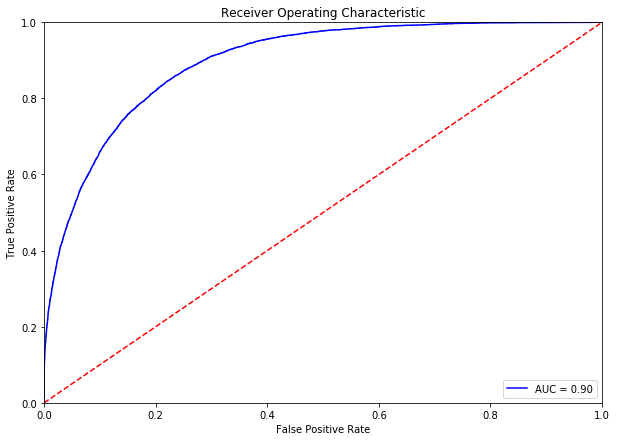

In [73]:
y_pred_proba = get_predictions(dataset, model_lr_rw)

fpr, tpr, thresholds = roc_curve(dataset.labels.ravel(), y_pred_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

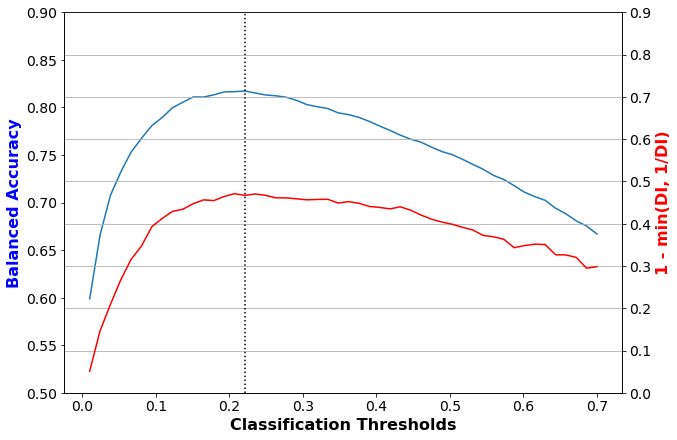

In [74]:
disp_imp = np.array(test_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

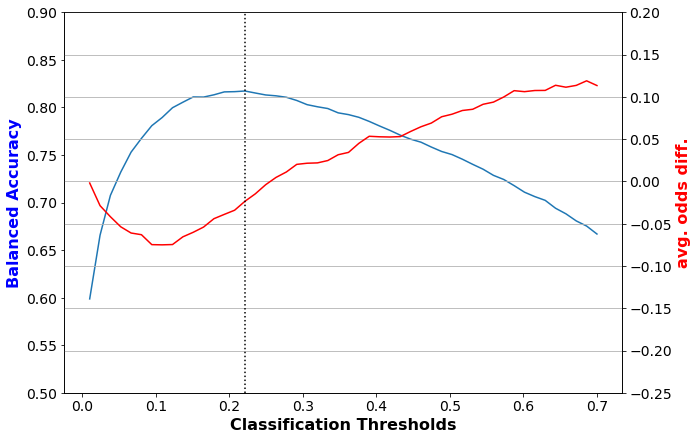

In [75]:
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     test_metrics['avg_odds_diff'], 'avg. odds diff.')

In [76]:
describe_metrics(test_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2212
Classification metrics:
Roc auc score: 0.9000
Best balanced accuracy: 0.8172
Corresponding precision: 0.5709
Corresponding recall: 0.8419
Fairness metrics:
Corresponding 1-min(DI, 1/DI) value: 0.4669
Corresponding average odds difference value: -0.0235
Corresponding statistical parity difference value: -0.2002
Corresponding equal opportunity difference value: 0.0500


### Random Forest

In [77]:
dataset = df_transf_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
model_rf_rw = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### Evaluacija

In [78]:
thresh_arr = np.linspace(0.01, 0.5, 50)
test_metrics = test(dataset=df_test,
                   model=model_rf_rw,
                   thresh_arr=thresh_arr)
rf_rw_best_ind = np.argmax(test_metrics['bal_acc'])


In [79]:
rf_rw_metrics = get_best_metrics(test_metrics, rf_rw_best_ind)

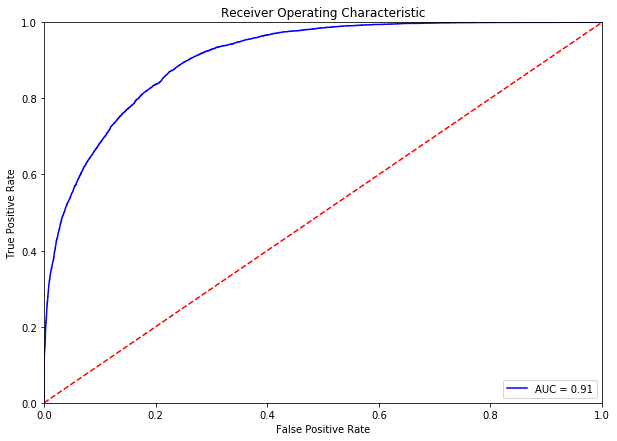

In [80]:
y_pred_proba = get_predictions(dataset, model_rf_rw)

fpr, tpr, thresholds = roc_curve(dataset.labels.ravel(), y_pred_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

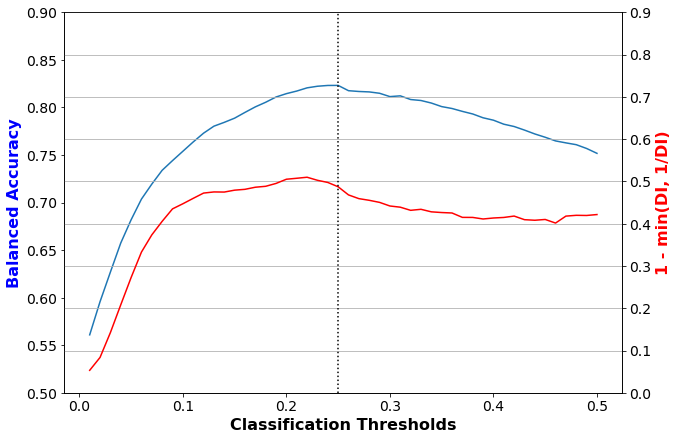

In [81]:
disp_imp = np.array(test_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

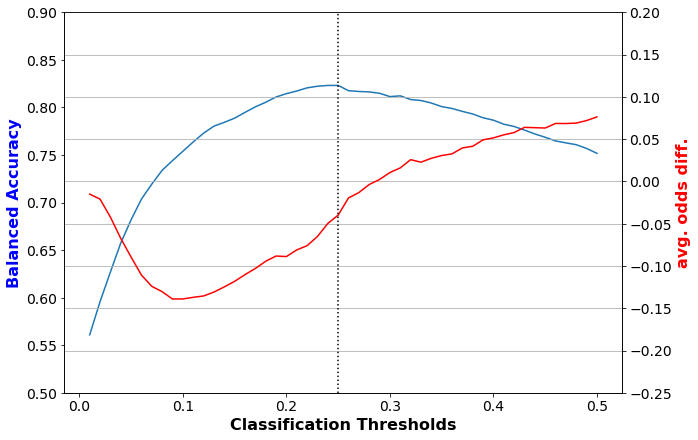

In [82]:
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     test_metrics['avg_odds_diff'], 'avg. odds diff.')

In [83]:
describe_metrics(test_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2500
Classification metrics:
Roc auc score: 0.9081
Best balanced accuracy: 0.8231
Corresponding precision: 0.5678
Corresponding recall: 0.8612
Fairness metrics:
Corresponding 1-min(DI, 1/DI) value: 0.4873
Corresponding average odds difference value: -0.0399
Corresponding statistical parity difference value: -0.2165
Corresponding equal opportunity difference value: 0.0312


### Disparate impact remover

## Tehnike promene algoritama

### Prejudice Remover 

In [84]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_scaler = StandardScaler()

dataset = df_train.copy()
dataset.features = pr_scaler.fit_transform(dataset.features)

model_pr = model.fit(dataset)

### Evaluacija

In [85]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = df_test.copy()
dataset.features = pr_scaler.transform(dataset.features)

test_metrics = test(dataset=dataset,
                   model=model_pr,
                   thresh_arr=thresh_arr)
pr_best_ind = np.argmax(test_metrics['bal_acc'])

In [86]:
pr_metrics = get_best_metrics(test_metrics, pr_best_ind)

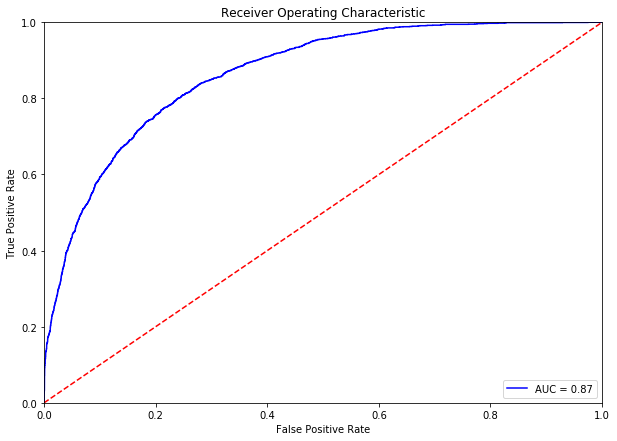

In [87]:
y_pred_proba = get_predictions(dataset, model_pr)

fpr, tpr, thresholds = roc_curve(dataset.labels.ravel(), y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

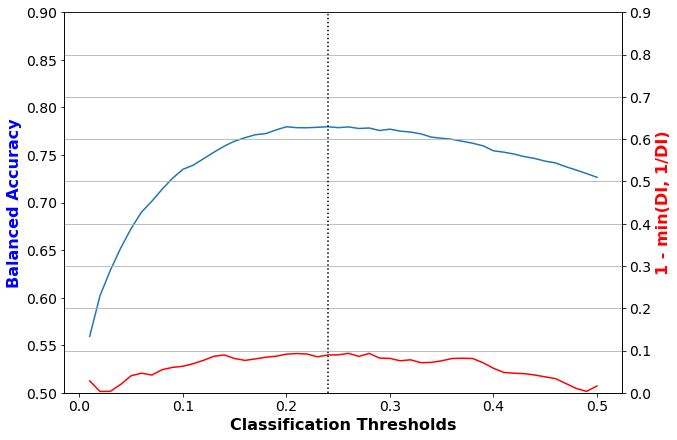

In [88]:
disp_imp = np.array(test_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

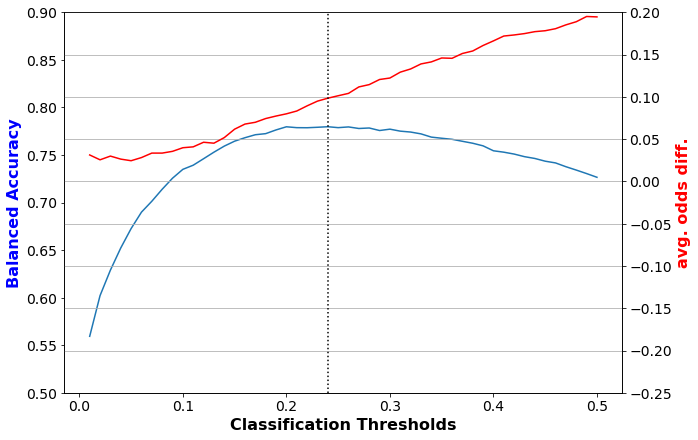

In [89]:
plot(thresh_arr, 'Classification Thresholds',
     test_metrics['bal_acc'], 'Balanced Accuracy',
     test_metrics['avg_odds_diff'], 'avg. odds diff.')

In [90]:
describe_metrics(test_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2400
Classification metrics:
Roc auc score: 0.8657
Best balanced accuracy: 0.7797
Corresponding precision: 0.5260
Corresponding recall: 0.7940
Fairness metrics:
Corresponding 1-min(DI, 1/DI) value: 0.0895
Corresponding average odds difference value: 0.0984
Corresponding statistical parity difference value: -0.0343
Corresponding equal opportunity difference value: 0.1205


### Adversarial debiasing

## Tehnike postprocesiranja

### RejectOptionClassification

In [91]:
dataset = df_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

model_lr = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [92]:
roc = RejectOptionClassification(unprivileged_groups, privileged_groups,
                low_class_thresh=0.01, high_class_thresh=0.99,
                num_class_thresh=100, num_ROC_margin=50,
                metric_name="Statistical parity difference",
                metric_ub=0.05, metric_lb=-0.05)

In [93]:
y_pred_proba = get_predictions(df_test, model_lr)
df_test_pred = df_test.copy()
df_test_pred.scores = y_pred_proba[:,1].reshape(-1,1)
df_test_pred.scores


array([[0.33625271],
       [0.24404842],
       [0.32868898],
       ...,
       [0.007824  ],
       [0.03253246],
       [0.80865715]])

In [94]:
class_thresh = 0.5
y_pred = np.zeros_like(df_test_pred.labels)
y_pred[y_pred_proba[:,1] >= class_thresh] = df_test_pred.favorable_label
y_pred[~(y_pred_proba[:,1] >= class_thresh)] = df_test_pred.unfavorable_label
df_test_pred.labels = y_pred

In [95]:
dataset_new = roc.fit_predict(df_test, df_test_pred)

In [96]:
metric = ClassificationMetric(
                df_test, dataset_new,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

In [97]:
lr_roc_metrics = get_metric_report(metric)

In [98]:
lr_roc_metrics

defaultdict(list,
            {'bal_acc': [0.7925837324034218],
             'precision': [0.506462674756001],
             'roc_auc': ['none'],
             'recall': [0.8598298253470668],
             'avg_odds_diff': [0.09339573290361805],
             'disp_imp': [0.8855952425927655],
             'stat_par_diff': [-0.04978829305381771],
             'eq_opp_diff': [0.12368187802239339]})

### Equalized odds postprocessing

In [99]:
eq = EqOddsPostprocessing(unprivileged_groups, privileged_groups)

In [100]:
y_pred_proba = get_predictions(df_test, model_lr)
df_test_pred = df_test.copy()
df_test_pred.scores = y_pred_proba[:,1].reshape(-1,1)
df_test_pred.scores

array([[0.33625271],
       [0.24404842],
       [0.32868898],
       ...,
       [0.007824  ],
       [0.03253246],
       [0.80865715]])

In [101]:
class_thresh = 0.5
y_pred = np.zeros_like(df_test_pred.labels)
y_pred[y_pred_proba[:,1] >= class_thresh] = df_test_pred.favorable_label
y_pred[~(y_pred_proba[:,1] >= class_thresh)] = df_test_pred.unfavorable_label
df_test_pred.labels = y_pred

In [102]:
dataset_new = eq.fit_predict(df_test, df_test_pred)

In [103]:
metric = ClassificationMetric(
                df_test, dataset_new,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

In [104]:
lr_eq_metrics = get_metric_report(metric)

In [105]:
lr_eq_metrics

defaultdict(list,
            {'bal_acc': [0.737989504572816],
             'precision': [0.6659685863874345],
             'roc_auc': ['none'],
             'recall': [0.5696372592924317],
             'avg_odds_diff': [0.002559399610945347],
             'disp_imp': [0.5988112413357144],
             'stat_par_diff': [-0.09731741680952147],
             'eq_opp_diff': [0.007809343187476281]})

## Poređenje rezultata

In [106]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, rf_orig_metrics, lr_rw_metrics,
           rf_rw_metrics, pr_metrics, lr_roc_metrics, lr_eq_metrics]
debias = pd.Series(['']*2 + ['Reweighing']*2
                 + ['Prejudice Remover'] + ['RejectOptionClassification'] + ['Equalized odds postprocessing'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression', 'Random Forest']*2 + [''] + ['Logistic Regression'] *2,
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,roc_auc,precision,recall,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff
Bias Mitigator,Classifier,,,,,,,,
,Logistic Regression,0.826266,0.908416,0.554869,0.885356,-0.187910,0.300290,-0.356023,-0.120788
,Random Forest,0.829754,0.913957,0.581248,0.863412,-0.185015,0.289421,-0.338122,-0.142458
Reweighing,Logistic Regression,0.817244,0.899998,0.570908,0.841917,-0.023498,0.533057,-0.200162,0.050007
Reweighing,Random Forest,0.823129,0.908099,0.567759,0.861173,-0.039908,0.512715,-0.216518,0.031156
Prejudice Remover,,0.779707,0.865699,0.525957,0.793999,0.098386,0.910522,-0.034339,0.120523
RejectOptionClassification,Logistic Regression,0.792584,none,0.506463,0.859830,0.093396,0.885595,-0.049788,0.123682
Equalized odds postprocessing,Logistic Regression,0.737990,none,0.665969,0.569637,0.002559,0.598811,-0.097317,0.007809
